In [12]:
import numpy as np
from scipy.spatial.distance import cityblock
import time

def uniform_sample_coreset(points, N=1000):
    """
    Construct a uniform random coreset by sampling points.

    Args:
        points: numpy array of shape (n, d) containing n d-dimensional points
        N: size of the coreset to construct

    Returns:
        coreset: numpy array of shape (N, d) containing the sampled points
        weights: uniform weights (all 1/N)
    """

    # Step 1: Randomly sample N points without replacement
    # If N is larger than the number of points, sample with replacement
    sampled_indices = np.random.choice(len(points), min(N, len(points)), replace=True)

    # Sample the points
    coreset = points[sampled_indices]

    # Create uniform weights
    weights = np.ones(N) / N

    return coreset, weights

def construct_strong_coreset(points, N=1000):
    """
    Construct a coreset for the 1-median problem in L1 through 2-step sampling.
    Args:
        points: numpy array of shape (n, d) containing n d-dimensional points
        N: size of the coreset to construct

    Returns:
        coreset: numpy array of shape (N, d) containing the coreset points
        weights: numpy array of shape (N,) containing the weights
    """
    n = len(points)

    # Step 1: Find approximate 1-median by sampling 100 points
    sample_indices = np.random.choice(n, min(1000, n), replace=True)
    samples = points[sample_indices]

    min_cost = float('inf')
    C_star = None

    for center in samples:
        # Using vectorized operations for speed
        distances = np.sum(np.abs(points - center), axis=1)
        cost = np.sum(distances)
        # print(cost)
        if cost < min_cost:
            min_cost = cost
            C_star = center

    # Vectorized computation of distances to C_star
    distances = np.sum(np.abs(points - C_star), axis=1)
    total_cost = np.sum(distances)
    sensitivities = distances / total_cost + 1/n

    # Step 3: Normalize sensitivities to probabilities
    probs = sensitivities / np.sum(sensitivities)
    # print(f"Sensitivities computed in {time.time() - start_time:.2f} seconds")

    # Step 4: Sample 100*N points according to these probabilities
    # print(f"Sampling {N} points...")
    first_sample_indices = np.random.choice(n, min(100*N, n), replace=True, p=probs)
    first_sample = points[first_sample_indices]
    first_weights = 1 / (len(first_sample_indices) * probs[first_sample_indices])

    # Second iteration
    # Find a better approximate 1-median using the first sample
    min_cost = float('inf')
    better_C_star = None

    for center in first_sample[np.random.choice(len(first_sample), min(100, len(first_sample)), replace=False)]:
        # Using vectorized operations for weighted distance calculation
        distances = np.sum(np.abs(first_sample - center), axis=1)
        weighted_cost = np.sum(distances * first_weights)
        if weighted_cost < min_cost:
            min_cost = weighted_cost
            better_C_star = center

    # Compute new sensitivities for the first sample
    distances = np.sum(np.abs(first_sample - better_C_star), axis=1)
    total_weighted_cost = np.sum(distances * first_weights)
    
    # Compute the sum of weights for normalization
    total_weight = np.sum(first_weights)
    
    # New sensitivity formula: w_x*dist/cost + weight/sum(weights)
    new_sensitivities = (first_weights * distances / total_weighted_cost) + (first_weights / total_weight)
    
    # Normalize to get probabilities
    second_probs = new_sensitivities / np.sum(new_sensitivities)
    
    # Sample final N points from the first sample
    second_sample_indices = np.random.choice(
        len(first_sample), 
        N, 
        replace=True, 
        p=second_probs
    )
    
    # Final coreset and weights
    coreset = first_sample[second_sample_indices]
    
    # The weights need to account for both sampling steps
    final_weights = 1 / (N * second_probs[second_sample_indices])
    final_weights *= first_weights[second_sample_indices]  # Multiply by first stage weights
    
    return coreset, final_weights


def construct_strong_coreset_one_iteration(points, N=1000):
    """
    Construct a coreset for the 1-median problem in L1 throught 2-step sampling.
    Args:
        points: numpy array of shape (n, d) containing n d-dimensional points
        N: size of the coreset to construct

    Returns:
        coreset: numpy array of shape (N, d) containing the coreset points
        weights: numpy array of shape (N,) containing the weights
    """
    n = len(points)

    # Step 1: Find approximate 1-median by sampling 100 points
    sample_indices = np.random.choice(n, min(1000, n), replace=True)
    samples = points[sample_indices]

    min_cost = float('inf')
    C_star = None

    for center in samples:
        # Using vectorized operations for speed
        distances = np.sum(np.abs(points - center), axis=1)
        cost = np.sum(distances)
        # print(cost)
        if cost < min_cost:
            min_cost = cost
            C_star = center

    # Vectorized computation of distances to C_star
    distances = np.sum(np.abs(points - C_star), axis=1)
    total_cost = np.sum(distances)
    sensitivities = distances / total_cost + 1/n

    # Step 3: Normalize sensitivities to probabilities
    probs = sensitivities / np.sum(sensitivities)
    # print(f"Sensitivities computed in {time.time() - start_time:.2f} seconds")

    # Step 4: Sample N points according to these probabilities
    # print(f"Sampling {N} points...")
    sampled_indices = np.random.choice(n, min(100*N, n), replace=True, p=probs)

    # Step 5: Reweight the sampled points
    coreset = points[sampled_indices]
    weights = 1 / (N * probs[sampled_indices])

    # print("Coreset construction complete")
    return coreset, weights


def generate_large_dataset(n=256000, d=64, num_clusters=5):
    """Generate a structured dataset with multiple clusters"""
    print(f"Generating dataset with {n} points in {d} dimensions...")
    start_time = time.time()

    # Create cluster centers
    centers = np.random.randn(num_clusters, d) * 10

    # Assign points to clusters with vectorized operations
    cluster_assignments = np.random.randint(0, num_clusters, size=n)
    noise = np.random.randn(n, d) * 2

    # Create points
    points = centers[cluster_assignments] + noise

    print(f"Dataset generated in {time.time() - start_time:.2f} seconds")
    return points

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pulp
from tqdm import tqdm

def compute_median(points, weights=None):
    """
    Compute the weighted median for a multidimensional point set using Linear Programming.

    Parameters:
    -----------
    points : numpy.ndarray
        Input points of shape (n, d), where n is number of points
        and d is the dimension
    weights : numpy.ndarray, optional
        Weights for each point. If None, uses standard median.

    Returns:
    --------
    numpy.ndarray
        Weighted median point of shape (d,)
    """
    # If no weights provided, use standard median
    if weights is None:
        return np.median(points, axis=0)

    # Compute weighted median for each coordinate using LP
    median = np.zeros(points.shape[1])

    for d in range(points.shape[1]):
        # Extract coordinates for this dimension
        coords = points[:, d]

        # Create the LP problem
        prob = pulp.LpProblem("Weighted_Median", pulp.LpMinimize)

        # Decision variable for median
        y = pulp.LpVariable("y")

        # Auxiliary variables for absolute deviation
        z = [pulp.LpVariable(f"z_{i}", lowBound=0) for i in range(len(coords))]

        # Objective function: minimize weighted absolute deviations
        prob += pulp.lpSum(weights[i] * z[i] for i in range(len(coords)))

        # Constraints
        for i in range(len(coords)):
            # z[i] >= |coords[i] - y|
            prob += z[i] >= coords[i] - y
            prob += z[i] >= y - coords[i]

        # Solve the problem
        prob.solve(pulp.PULP_CBC_CMD(msg=False))

        # Store the optimal median for this dimension
        median[d] = y.varValue

    return median


def evaluate_coreset(original_points, coreset, weights=None):
    """
    Evaluate the quality of the coreset by comparing costs.

    Returns:
        Relative error of the coreset approximation
    """
    # Get the median of original points (coordinate-wise median)
    true_median = compute_median(original_points)
    # print("true median", true_median)

    # Compute cost using original dataset
    original_cost = np.sum(np.sum(np.abs(original_points - true_median), axis=1))

    # Compute cost using coreset and weights
    coreset_median = compute_median(coreset, weights)
    # print("coreset_median", coreset_median)
    coreset_cost = np.sum(np.sum(np.abs(original_points - coreset_median), axis=1))
    # Compute relative error
    relative_error = abs(original_cost - coreset_cost) / original_cost

    return relative_error


def compare_coreset_methods(df, coreset_sizes=None, n_repeats=10):
    """
    Compare uniform and importance sampling coreset construction methods.

    Args:
        df: DataFrame containing float columns
        coreset_sizes: List of coreset sizes to test (default: 50 to 2000)
        n_repeats: Number of repeats for both methods to calculate standard deviation

    Returns:
        Dictionary of results for plotting
    """
    import time
    
    points = df.values
    # Default coreset sizes if not provided
    if coreset_sizes is None:
        coreset_sizes = list(range(100, 1001, 50))

    # Initialize result tracking
    uniform_errors = []
    uniform_errors_std = []
    importance_errors = []
    importance_errors_std = []
    
    # Track construction times
    uniform_times = []
    importance_times = []

    # Test for different coreset sizes
    for N in tqdm(coreset_sizes, desc="Testing coreset sizes"):
        # For uniform sampling, run multiple times to get mean and std
        uniform_errors_n = []
        importance_errors_n = []
        uniform_times_n = []
        importance_times_n = []
        
        for _ in range(n_repeats):
            # Uniform Sampling with timing
            start_time = time.time()
            uniform_coreset, uniform_weights = uniform_sample_coreset(points, N)
            uniform_time = time.time() - start_time
            uniform_times_n.append(uniform_time)
            
            uniform_error = evaluate_coreset(points, uniform_coreset, uniform_weights)
            uniform_errors_n.append(uniform_error)
            
            # Importance Sampling with timing
            start_time = time.time()
            importance_coreset, importance_weights = construct_strong_coreset(points, N)
            importance_time = time.time() - start_time
            importance_times_n.append(importance_time)
            
            importance_error = evaluate_coreset(points, importance_coreset, importance_weights)
            importance_errors_n.append(importance_error)

        # Store results
        uniform_errors.append(np.mean(uniform_errors_n))
        uniform_errors_std.append(np.std(uniform_errors_n))
        importance_errors.append(np.mean(importance_errors_n))
        importance_errors_std.append(np.std(importance_errors_n))
        
        # Store timing information
        uniform_times.append(np.mean(uniform_times_n))
        importance_times.append(np.mean(importance_times_n))

    # Calculate average construction time across all sizes
    avg_uniform_time = np.mean(uniform_times)
    avg_importance_time = np.mean(importance_times)

    # Prepare results for plotting and analysis
    results = {
        'coreset_sizes': coreset_sizes,
        'uniform_errors': uniform_errors,
        'uniform_errors_std': uniform_errors_std,
        'importance_errors': importance_errors,
        'importance_errors_std': importance_errors_std,
        'avg_uniform_time': avg_uniform_time,
        'avg_importance_time': avg_importance_time
    }

    return results


In [14]:
# !pip install scanpy

In [15]:
import scanpy as sc

# Read the h5 file
adata = sc.read_10x_h5('l1_data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')

/Users/amc9812/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/amc9812/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
import pandas as pd

genomic_df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

# Optional: filter to only RNA features if there are multiple feature types
rna_features = adata.var[adata.var['feature_types'] == 'Gene Expression'].index
genomic_df = genomic_df[rna_features]

genomic_df.shape

(7865, 33586)

In [17]:
from matplotlib.ticker import ScalarFormatter

def dimension_experiment(df, coreset_sizes, num_repeats = 20):
    """
    Experiment to evaluate uniform sampling across different dimensions
    """
    # If max_dimensions not specified, use total number of columns
    max_dimensions = df.shape[1]

    # Prepare results storage
    results = {size: {'mean': [], 'std': []} for size in coreset_sizes}
    dimensions = list(range(100, max_dimensions + 1, 250))  

    # Run experiment
    for dim in tqdm(dimensions, desc="Processing dimensions"):
        dim_errors = {size: [] for size in coreset_sizes}
        for _ in range(num_repeats):
            selected_columns = np.random.choice(
                max_dimensions, 
                size=dim, 
                replace=False
            )
            points = df.iloc[:, selected_columns].values
            for size in coreset_sizes:
                sampled_indices = np.random.choice(len(points), size, replace=True)
                uniform_coreset = points[sampled_indices]
                error = evaluate_coreset(points, uniform_coreset)
                dim_errors[size].append(error)
        for size in coreset_sizes:
            results[size]['mean'].append(np.mean(dim_errors[size]))
            results[size]['std'].append(np.std(dim_errors[size]))

    return dimensions, results

In [24]:
sampled_columns = np.random.choice(genomic_df.columns, size=1000, replace=False)
genomic_df_sampled = genomic_df[sampled_columns]

In [25]:
genomic_df.shape

(7865, 33586)

In [26]:
coresets_sizes=[150, 300, 500]
# Assuming 'float_df' is your DataFrame from previous processing
dimensions, results = dimension_experiment(genomic_df,coresets_sizes, 20)
# plot_dimension_experiment(dimensions, results, 20)

Processing dimensions: 100%|██████████████████████| 4/4 [00:05<00:00,  1.44s/it]


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from scipy import stats

def plot_dimension_experiment(dimensions, results, num_repeats=20, ci_style='smeared', log_x=True):
    """
    Create a plot with linear trend lines, slopes in legend, and confidence intervals.
    
    Args:
        dimensions: List of dimension values
        results: Dictionary mapping coreset sizes to results with 'mean' and 'std'
        num_repeats: Number of repetitions in the experiment
        ci_style: Style of confidence intervals - 'bars' (error bars) or 'smeared' (shaded area)
        log_x: Whether to use log scale for x-axis (affects slope interpretation)
    
    Returns:
        Matplotlib figure
    """
    sns.set_theme(style="whitegrid")
    
    # Scientific color scheme - colorblind friendly and distinguishable
    colors = ['#0173B2',  # Blue
              '#DE8F05',  # Orange
              '#029E73',  # Green
              '#D55E00',  # Red
              '#CC78BC',  # Purple
              '#CA9161']  # Brown
    
    # Set up a figure and axes
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Set x-axis to log scale if requested
    if log_x:
        ax.set_xscale('log', base=2)  # Use log base 2
        # For regression with log scale, we need to use log of dimensions
        x_for_regression = np.log2(dimensions)
    else:
        x_for_regression = np.array(dimensions)
    
    # Plot lines and confidence intervals for each coreset size
    for i, size in enumerate(sorted(results.keys())):
        # Extract mean and std values
        mean_values = np.array(results[size]['mean']) * 100  # Convert to percentage
        std_values = np.array(results[size]['std']) * 100    # Convert to percentage
        
        # Fit linear regression to means (using log dimensions if log_x is True)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_for_regression, mean_values)
        # print("slope")
        # print(slope)
        # Calculate fitted mean values
        fitted_mean = slope * x_for_regression + intercept
        
        # Calculate standard error of the mean
        sem = std_values / np.sqrt(num_repeats)
        slope_label = "slope"
        # # Format slope value for legend with appropriate interpretation
        # if log_x:
        #     # For log2 scale, slope represents change in Y for a doubling of X
        #     slope_label = "log2_slope"
        # else:
        #     slope_label = "slope"
        slope_formatted = f"{slope:.4f}"
        # if abs(slope) < 0.001:
        #     slope_formatted = f"{slope:.2e}"
        # elif abs(slope) < 0.01:
        #     slope_formatted = f"{slope:.4f}"
        # else:
        #     slope_formatted = f"{slope:.3f}"
        
        # Draw the regression line
        if log_x:
            # For log scale, create points for a smooth curve
            log_x_points = np.linspace(np.log2(min(dimensions)), np.log2(max(dimensions)), 100)
            log_y_points = slope * log_x_points + intercept
            
            # Convert back to original scale for plotting
            x_points = 2**log_x_points
            plt.plot(x_points, log_y_points, '-', color=colors[i % len(colors)], 
                    linewidth=2.5, label=f'Size {size} ({slope_label}={slope_formatted})')
        else:
            # For linear scale, just use the endpoints
            line_x = np.array([min(dimensions), max(dimensions)])
            line_y = slope * line_x + intercept
            plt.plot(line_x, line_y, '-', color=colors[i % len(colors)], 
                    linewidth=2.5, label=f'Size {size} ({slope_label}={slope_formatted})')
        
        # Add confidence intervals based on user preference
        if ci_style == 'bars':
            # Add error bars at data points, but don't show the dots
            plt.errorbar(dimensions, fitted_mean, yerr=sem, fmt='none', 
                        color=colors[i % len(colors)], elinewidth=1.5, 
                        capsize=4, alpha=0.7)
                
        elif ci_style == 'smeared':
            # Add confidence band as a shaded area
            plt.fill_between(dimensions, 
                            fitted_mean - sem,
                            fitted_mean + sem, 
                            color=colors[i % len(colors)], alpha=0.2)
        else:
            pass
    
    # Improve formatting
    ax.yaxis.set_major_formatter(ScalarFormatter())
    
    # Labels with log scale indicator if applicable
    x_label = 'Number of Dimensions (log scale)' if log_x else 'Number of Dimensions' 
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel('Relative Error (%)', fontsize=14)
    
    # Add grid lines
    ax.grid(True, alpha=0.3)
    
    # Enhance tick label styling
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Create the legend
    legend = ax.legend(
        title='Coreset Size',
        title_fontsize=13,
        fontsize=12,
        frameon=True,
        framealpha=0.9,
        edgecolor='gray',
        fancybox=False,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.85)
    )
    
    # Tighten layout
    plt.tight_layout()
    
    # Filename with log indicator if using log scale
    filename = 'figures/dimension_experiment.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

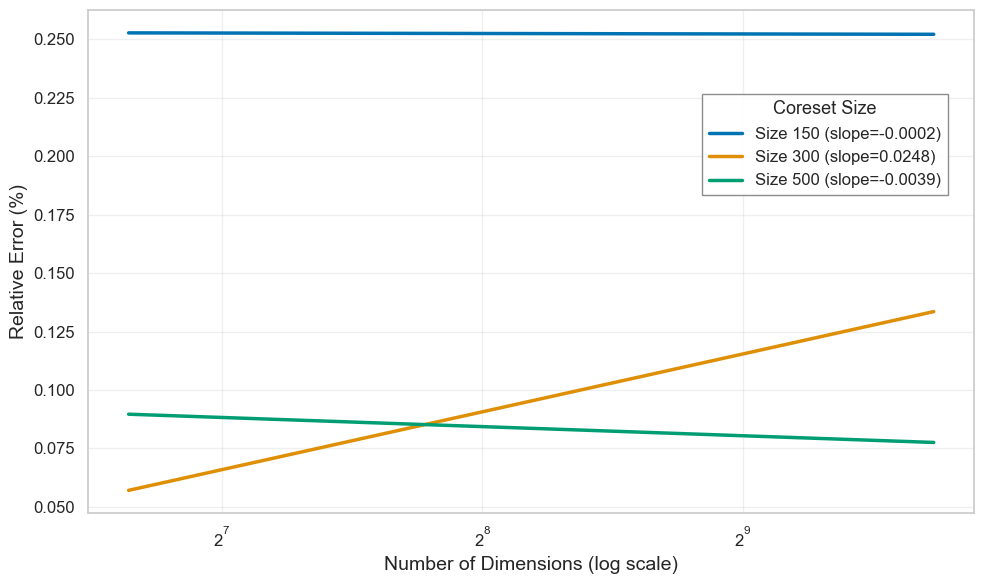

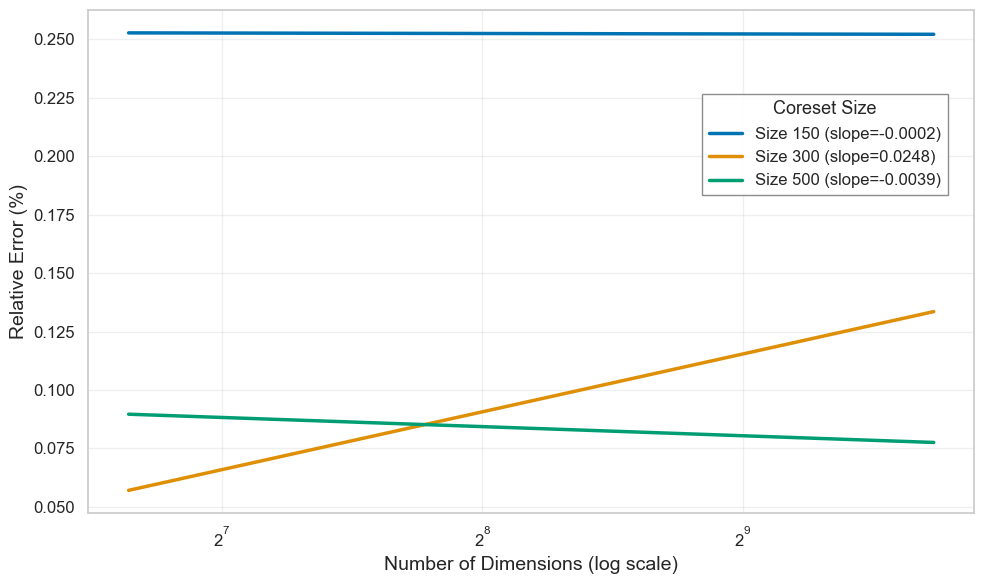

In [28]:
plot_dimension_experiment(dimensions, results, 20, None, True)